## IMPORT FILES

In [1]:
###Import Libraries
#import geopandas as gpd
import pandas as pd
#from haversine import haversine
import math
import numpy as np
from ggplot import *

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
#import folium
#import folium.colormap as cm
#from branca.colormap import linear
from sklearn.preprocessing import scale
import seaborn as sns
from pandas.plotting import table

C:\Users\HP\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\HP\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools




## CDF CLUSTERING

In [2]:
###Function for binning
def binit(start,end,size):
    bins=[]
    j=start
    k=(end-start)/size
    for i in range(size-1):
        j=j+k
        bins=bins+[j]
    return bins

###Function for CDF 
def cdf(row,df,value,ref):
    df_temp1=df.loc[(df[ref]==row[var_scale])&(df[value]<=row['Cutoff']),ref]
    df_temp2=df.loc[(df[ref]==row[var_scale]),ref]
    return float(len(df_temp1))/((float(len(df_temp2)))+0.0000000001)

###Function for creating cut_off bins
def cob(df,var_study,var_scale,bins):
    df_1=pd.DataFrame(data={'Cutoff':bins})
    #print(df_1)
    df_2=pd.DataFrame(data={var_scale:df[var_scale].unique()})
    #print(df_2)
    df_1['key']=1
    df_2['key']=1
    df_cluster=df_1.merge(df_2, right_on='key', left_on='key', how='inner')
    del df_cluster['key'], df_1, df_2
    df_cluster[var_study]=df_cluster.apply( lambda row: cdf(row,df_Vill,var_study,var_scale), axis=1)
    return df_cluster

#### Main

In [3]:
###Import Village, District, State Files
df_Vill=pd.read_csv('FINALSUM.csv')
df_VillDEMO=pd.read_csv('FINALSUM.csv')



df_Vill = df_Vill[df_Vill.avg_rad != 0]
#df_Vill['MSW_ADV']
df_Vill=df_Vill.dropna(subset=['DISTRICT'])


C:\Users\HP\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4,7,8,9,10,18,21,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
###Preprocess Literacy Here
#df_Vill.groupby('DISTRICT').size()

df_Vill.shape

(197909, 28)

In [5]:
#df_VillDEMO.groupby('DISTRICT').size()


(array([149125.,  24177.,   9101.,   4623.,   2703.,   1690.,   1145.,
           802.,    636.,    451.]),
 array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000., 18000., 20000.]),
 <a list of 10 Patch objects>)

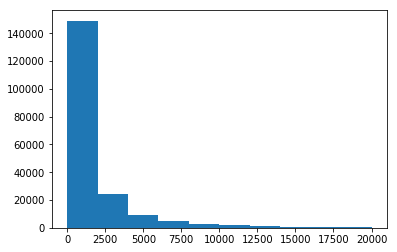

In [5]:
###Declare variable and scale
var_study='avg_rad'
var_scale='DISTRICT'
plt.hist(df_Vill[var_study],range=[0,20000])


In [6]:

df_Vill = df_Vill.drop(df_Vill[df_Vill.avg_rad >13000].index)



In [7]:
df_Vill.shape


(192035, 28)

In [8]:
df_VillDEMO.shape

(197962, 28)

In [8]:
OldMin=df_Vill[var_study].min()
OldMax=df_Vill[var_study].max()
OldRange = (OldMax - OldMin)  
#print(OldRange)
NewMin=0
NewMax=100
NewRange = (100 - 0) 
NewValue=[]
j=0
for i in df_Vill['avg_rad']:
    temp=(((i - OldMin) * NewRange) / OldRange) + NewMin
    NewValue.append(temp)
se = pd.Series(NewValue)
df_Vill['Norm_avg']=se.values
var_study1='Norm_avg'

#print(df_Vill['Norm_avg'])

In [13]:
###Creating bins for CDF
print(df_Vill[var_study].max())
print(df_Vill[var_study].min())
bins=binit(df_Vill[var_study].min(),df_Vill[var_study].max(),20)
print(bins)
###creating dataframe with CDF
df_cluster=cob(df_Vill, var_study, var_scale,bins)
#print(df_cluster)

12999.474031818609
0.002494144673440971
[649.9760710283701, 1299.949647912067, 1949.9232247957636, 2599.8968016794606, 3249.8703785631574, 3899.843955446854, 4549.817532330551, 5199.791109214248, 5849.764686097944, 6499.73826298164, 7149.7118398653365, 7799.685416749033, 8449.65899363273, 9099.632570516425, 9749.606147400122, 10399.579724283818, 11049.553301167514, 11699.52687805121, 12349.500454934907]


In [18]:
df_cluster=df_cluster.dropna()
len(df_cluster['DISTRICT'].unique())

175

(175, 19)
(175, 9)


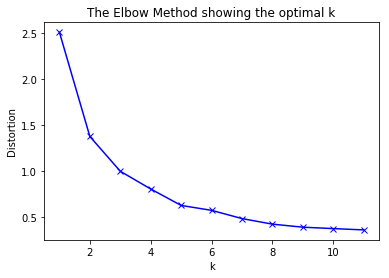

In [20]:
###Creating CDF for a variable
df1=df_cluster.pivot(index=var_scale, columns='Cutoff')[var_study]
print(df1.shape)
X=np.array(df1)
X=scale(X[:,0:9], axis=0)
print(X.shape)
###k means determine k
distortions = []
K = range(1,12)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

###Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [13]:
### The Clustering model and label generation
kmeanModel = KMeans(n_clusters=3).fit(X)

df_labels= pd.DataFrame(data={var_scale:df1.index, var_scale+'_CDF_Labels_'+var_study :kmeanModel.labels_})
df_labels.groupby('DISTRICT_CDF_Labels_avg_rad').count()

,DISTRICT
DISTRICT_CDF_Labels_avg_rad,
0,55
1,17
2,103


In [14]:
df_labels

,DISTRICT,DISTRICT_CDF_Labels_avg_rad
0,Ahmadabad,1
1,Ahmadnagar,0
2,Akola,2
3,Alappuzha,1
4,Amravati,2
5,Amreli,0
6,Anand,0
7,Anugul,2
8,Araria,2
9,Aurangabad,2


In [ ]:
#df_cdfVill=df_Vill.merge(df_labels, left_on= var_scale ,right_on=var_scale, how='left')


In [ ]:
#df_cdfVill=df_cdfVill.dropna
#print(var_scale)


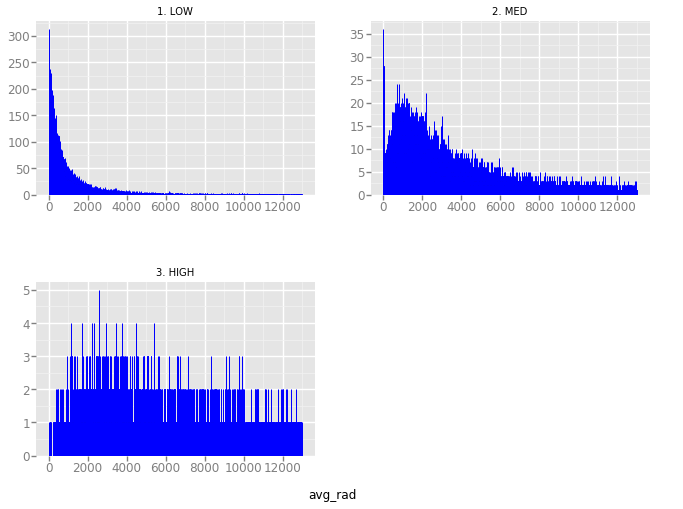

In [84]:
### Displaying plot for correct labelling

df_cdfVill=df_Vill.merge(df_labels, left_on= var_scale ,right_on=var_scale, how='left')
#df_cdfVill.dropna()
#plt.hist(df_cdfVill)
#plt.hist(df_cdfVill)
plot= ggplot(df_cdfVill, aes(x=var_study))+geom_histogram(binwidth=1, color='blue')+facet_wrap(var_scale+'_CDF_Labels_'+var_study, scales='free_y')
del df_cdfVill
plot
plot.save('SUM_VIIRS_Results_3_Clusters.png')


In [83]:
### Correcting the labels
df_labels.loc[df_labels[var_scale+'_CDF_Labels_'+var_study]==1,var_scale+'_CDF_Labels_'+var_study]="1. LOW"
df_labels.loc[df_labels[var_scale+'_CDF_Labels_'+var_study]==0,var_scale+'_CDF_Labels_'+var_study]="2. MED"
df_labels.loc[df_labels[var_scale+'_CDF_Labels_'+var_study]==2,var_scale+'_CDF_Labels_'+var_study]="3. HIGH"


In [85]:
#Saving the labels
df_labels.to_csv("cdf_viirs_sumMAIN26_6.csv")